# Flight price prediction

### Problem Statement

Anyone who has booked a flight ticket knows how unexpectedly the prices vary. The cheapest
available ticket on a given flight gets more and less expensive over time. This usually happens as
an attempt to maximize revenue based on -
1. Time of purchase patterns (making sure last-minute purchases are expensive)
2. Keeping the flight as full as they want it (raising prices on a flight which is filling up in order
to reduce sales and hold back inventory for those expensive last-minute expensive
purchases)
So, you have to work on a project where you collect data of flight fares with other features and
work to make a model to predict fares of flights.

In [98]:
#importing the libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix,classification_report
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

### Importing dataset
1. Data scrapped from the yatra.com and EsayMyTrip com 

In [99]:
#loading the data set
df= pd.read_csv('EasyMyTrip_Yatra_2021.csv')
df.head()

,Date,Airline,Source,Destination,Dep_time,Arr_time,Durtion,Route,stop,price
0,25-Oct,GO FIRST,Bangalore,Delhi,6:00,8:40,02h 40m,BLR--->DEL,non-stop,"7,487"
1,25-Oct,GO FIRST,Bangalore,Delhi,21:15,23:55,02h 40m,BLR--->DEL,non-stop,"7,487"
2,25-Oct,SpiceJet,Bangalore,Delhi,2:10,4:50,02h 40m,BLR--->DEL,non-stop,"7,488"
3,25-Oct,Indigo,Bangalore,Delhi,12:55,15:40,02h 45m,BLR--->DEL,non-stop,"7,488"
4,25-Oct,Indigo,Bangalore,Delhi,14:35,17:20,02h 45m,BLR--->DEL,non-stop,"7,488"


In [100]:
df.shape

(7699, 10)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7699 entries, 0 to 7698
Data columns (total 10 columns):
Date           7699 non-null object
Airline        7699 non-null object
Source         7699 non-null object
Destination    7699 non-null object
Dep_time       7699 non-null object
Arr_time       7699 non-null object
Durtion        7699 non-null object
Route          7699 non-null object
stop           7699 non-null object
price          7699 non-null object
dtypes: object(10)
memory usage: 601.6+ KB


## Data cleaning 

In [102]:
#### Checking null values
df.isnull().sum()

Date           0
Airline        0
Source         0
Destination    0
Dep_time       0
Arr_time       0
Durtion        0
Route          0
stop           0
price          0
dtype: int64

In [103]:
df.dropna(inplace = True)

In [104]:
##Droping the Unamed columns 

df.dropna(subset=['price'],inplace = True)

In [105]:
df.isnull().sum()

Date           0
Airline        0
Source         0
Destination    0
Dep_time       0
Arr_time       0
Durtion        0
Route          0
stop           0
price          0
dtype: int64

In [106]:
#converting the objects to hours,minutes
df["Dep_hour"] = pd.to_datetime(df["Dep_time"]).dt.hour
df["Dep_min"] = pd.to_datetime(df["Dep_time"]).dt.minute
df.drop(["Dep_time"], axis = 1, inplace = True)

In [107]:
#converting the objects to hours, minutes
df["Arr_hour"] = pd.to_datetime(df["Arr_time"]).dt.hour
df["Arr_min"] = pd.to_datetime(df["Arr_time"]).dt.minute
df.drop(["Arr_time"], axis = 1, inplace = True)

In [108]:
df.head()

,Date,Airline,Source,Destination,Durtion,Route,stop,price,Dep_hour,Dep_min,Arr_hour,Arr_min
0,25-Oct,GO FIRST,Bangalore,Delhi,02h 40m,BLR--->DEL,non-stop,"7,487",6,0,8,40
1,25-Oct,GO FIRST,Bangalore,Delhi,02h 40m,BLR--->DEL,non-stop,"7,487",21,15,23,55
2,25-Oct,SpiceJet,Bangalore,Delhi,02h 40m,BLR--->DEL,non-stop,"7,488",2,10,4,50
3,25-Oct,Indigo,Bangalore,Delhi,02h 45m,BLR--->DEL,non-stop,"7,488",12,55,15,40
4,25-Oct,Indigo,Bangalore,Delhi,02h 45m,BLR--->DEL,non-stop,"7,488",14,35,17,20


In [109]:
#replace the h,m from the duration 
df['Durtion']=df['Durtion'].str.replace("h",':')
df['Durtion']=df['Durtion'].str.replace("m",'')
df['Durtion']=df['Durtion'].str.replace(" ",'')

#spliting the hours and minutes 
df["Dur_hour"]=df['Durtion'].str.split(':').str[0]
df["Dur_min"]=df['Durtion'].str.split(':').str[1]
df.drop(["Durtion"], axis = 1, inplace = True)

In [110]:
#removing the comma symbole form price
df['price']=df['price'].str.replace(",","")

In [111]:
df['Day']=df['Date'].str.split("-").str[0]
df['Month']=df['Date'].str.split("-").str[1]


In [112]:
df.drop(["Date"], axis = 1, inplace = True)

In [113]:
column=['Airline', 'Source', 'Destination', 'Day', 'Month','Route','Dep_hour','Dep_min', 'Dur_hour','Dur_min','Arr_hour','Arr_min','stop','price']
  
# create the new index for columns
df=df.reindex(column, axis='columns')

In [114]:
df.head()

,Airline,Source,Destination,Day,Month,Route,Dep_hour,Dep_min,Dur_hour,Dur_min,Arr_hour,Arr_min,stop,price
0,GO FIRST,Bangalore,Delhi,25,Oct,BLR--->DEL,6,0,02,40,8,40,non-stop,7487
1,GO FIRST,Bangalore,Delhi,25,Oct,BLR--->DEL,21,15,02,40,23,55,non-stop,7487
2,SpiceJet,Bangalore,Delhi,25,Oct,BLR--->DEL,2,10,02,40,4,50,non-stop,7488
3,Indigo,Bangalore,Delhi,25,Oct,BLR--->DEL,12,55,02,45,15,40,non-stop,7488
4,Indigo,Bangalore,Delhi,25,Oct,BLR--->DEL,14,35,02,45,17,20,non-stop,7488


In [115]:
df.to_csv("EasyMyTrip_yatra_Cleaned.csv")

In [116]:
#df=pd.read_csv("Cleaned_EasyMytrip.csv")
#df.head()

In [117]:
#df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [118]:
"""
df["Dep_hour"] = pd.to_datetime(df["Dep_hour"]).dt.hour
df["Dep_min"] = pd.to_datetime(df["Dep_min"]).dt.minute
df["Arr_hour"] = pd.to_datetime(df["Arr_hour"]).dt.hour
df["Arr_min"] = pd.to_datetime(df["Arr_min"]).dt.minute
df["Dur_hour"] = pd.to_datetime(df["Dur_hour"]).dt.hour
df["Dur_min"] = pd.to_datetime(df["Dur_min"]).dt.minute
"""

#converting to date fomate 

df["Day"] = pd.to_datetime(df.Day, format="%d").dt.day
df['Month'] =df['Month'].str.replace('Oct','10')
df['Month'] =df['Month'].str.replace('Nov','11')
df["Month"] = pd.to_datetime(df["Month"], format = "%m").dt.month

In [119]:
#converting object to numeric data type 
df["Dep_hour"]=pd.to_numeric(df["Dep_hour"])
df["Dur_min"]=pd.to_numeric(df["Dur_min"])
df['price']=pd.to_numeric(df['price'])

In [120]:
df.head()

,Airline,Source,Destination,Day,Month,Route,Dep_hour,Dep_min,Dur_hour,Dur_min,Arr_hour,Arr_min,stop,price
0,GO FIRST,Bangalore,Delhi,25,10,BLR--->DEL,6,0,02,40,8,40,non-stop,7487
1,GO FIRST,Bangalore,Delhi,25,10,BLR--->DEL,21,15,02,40,23,55,non-stop,7487
2,SpiceJet,Bangalore,Delhi,25,10,BLR--->DEL,2,10,02,40,4,50,non-stop,7488
3,Indigo,Bangalore,Delhi,25,10,BLR--->DEL,12,55,02,45,15,40,non-stop,7488
4,Indigo,Bangalore,Delhi,25,10,BLR--->DEL,14,35,02,45,17,20,non-stop,7488


### Exploratory data Analysis

#### Univariant Analysis

Vistara      1986
Indigo       1234
Air India    1212
GO FIRST     1014
AirAsia       843
IndiGo        602
SpiceJet      519
Go First      236
Air Asia       53
Name: Airline, dtype: int64


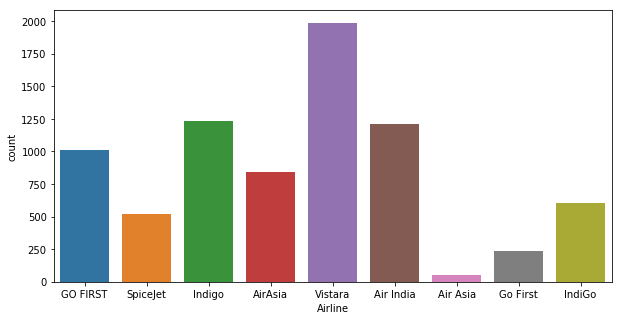

In [121]:
fig=plt.figure(figsize=(10,5))
sns.countplot(df['Airline'])
print(df['Airline'].value_counts())
plt.show()

Descrpition: indigo Have highest number of flights in demostic

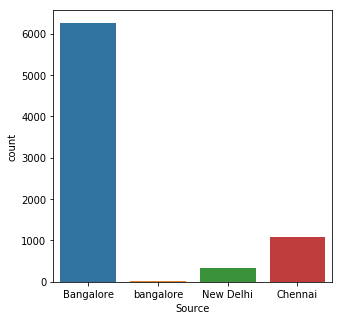

In [122]:
fig=plt.figure(figsize=(5,5))
sns.countplot(df['Source'])
plt.show()

Delhi     7369
Mumbai     330
Name: Destination, dtype: int64


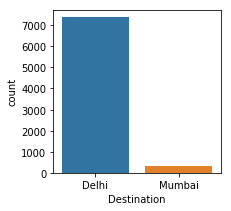

In [123]:
fig=plt.figure(figsize=(3,3))
sns.countplot(df['Destination'])
print(df['Destination'].value_counts())
plt.show()

23    383
22    313
21    304
20    303
17    302
16    293
18    292
25    292
19    287
28    284
1     284
27    271
24    269
2     268
31    261
26    260
29    257
30    245
15    211
9     206
8     205
14    196
5     196
13    195
11    194
12    194
10    193
7     189
6     188
3     184
4     180
Name: Day, dtype: int64


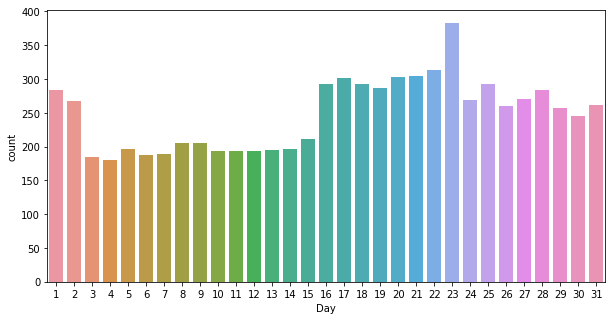

In [124]:
#number of flights from bangalore to delhi
fig=plt.figure(figsize=(10,5))
sns.countplot(df['Day'])
print(df['Day'].value_counts())
plt.show()

11    5128
10    2571
Name: Month, dtype: int64


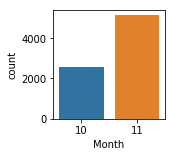

In [125]:
fig=plt.figure(figsize=(2,2))
sns.countplot(df['Month'])
print(df['Month'].value_counts())
plt.show()

In [126]:
#flight routes
print(df['Route'].unique())

['BLR--->DEL' 'BLR--->BOM-->DEL' 'BLR--->GOI-->DEL' 'BLR--->CCU-->DEL'
 'BLR--->COK-->DEL' 'BLR--->IXR-->DEL' 'BLR--->IXB-->DEL'
 'BLR--->GAU-->DEL' 'BLR--->HYD-->DEL' 'BLR--->LKO-->DEL'
 'BLR--->AMD-->DEL' 'BLR--->VNS-->DEL' 'BLR--->NAG-->DEL'
 'BLR--->BDQ-->DEL' 'BLR--->JAI-->DEL' 'BLR--->MAA-->DEL'
 'BLR--->UDR-->DEL' 'BLR--->STV-->DEL' 'BLR--->SAG-->DEL'
 'BLR--->JLR-->DEL' 'BLR--->BBI-->DEL' 'BLR--->PAT-->DEL'
 'BLR--->IXC-->DEL' 'BLR--->PNQ-->DEL' 'BLR--->VTZ-->DEL'
 'BLR--->BHO-->DEL' 'BLR--->TRV-->DEL' 'BLR-->DEL' 'DEL-->BOM' 'MAA-->DEL']


1-stop      6209
non-stop    1355
2-stop       123
3-stop        12
Name: stop, dtype: int64


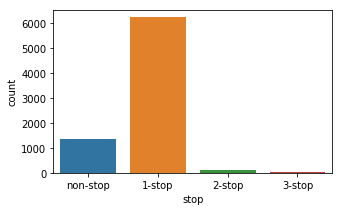

In [127]:
fig=plt.figure(figsize=(5,3))
sns.countplot(df['stop'])
print(df['stop'].value_counts())
plt.show()

### Multivrient analysis

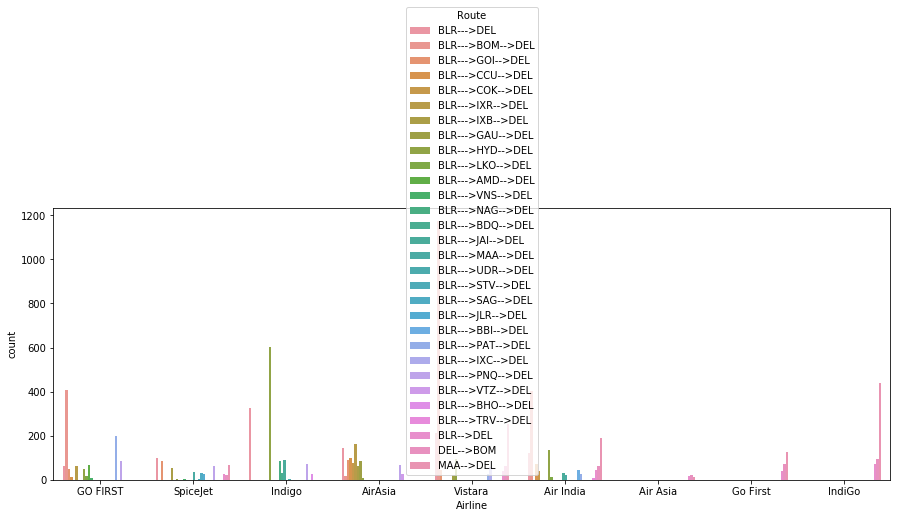

In [128]:
fig=plt.figure(figsize=(15,5))
sns.countplot(x='Airline',hue='Route',  data=df)
plt.show()

In [129]:
# Minmum price of the flight of that day
df.groupby(df['Day'])['price'].min()

Day
1     7350
2     6050
3     7485
4     6186
5     7485
6     7485
7     7485
8     7404
9     6186
10    7485
11    7485
12    7485
13    7485
14    7485
15    7485
16    6186
17    2270
18    2270
19    3916
20    3916
21    3916
22    3916
23    3861
24    3916
25    3861
26    7352
27    7352
28    7352
29    7352
30    7352
31    7350
Name: price, dtype: int64

In [130]:
#Minimum Airline fare 
df.groupby(["Source", "Destination"])["price"].min()

Source     Destination
Bangalore  Delhi          3861
Chennai    Delhi          2270
New Delhi  Mumbai         5953
bangalore  Delhi          5953
Name: price, dtype: int64

In [131]:
#Cheap airline fare for the days with source and destination 
df.groupby(["Source", "Destination",'Day','Month'])["price"].min()

Source     Destination  Day  Month
Bangalore  Delhi        1    11       7485
                        2    11       7485
                        3    11       7485
                        4    11       6186
                        5    11       7485
                        6    11       7485
                        7    11       7485
                        8    11       7404
                        9    11       6186
                        10   11       7485
                        11   11       7485
                        12   11       7485
                        13   11       7485
                        14   11       7485
                        15   11       7485
                        16   11       6186
                        17   11       7485
                        18   11       4744
                        19   11       3916
                        20   11       3916
                        21   11       3916
                        22   10       7485
                   

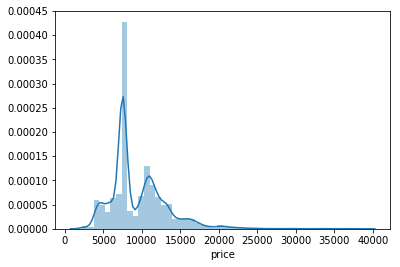

In [132]:
sns.distplot(df["price"])

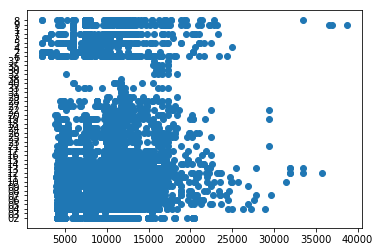

In [133]:
plt.scatter(df['price'],df['Dur_hour'])

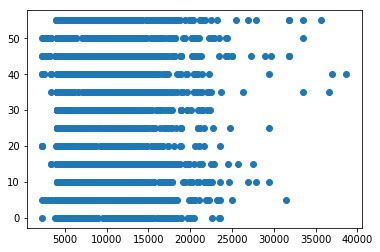

In [134]:
plt.scatter(df['price'],df['Dur_min'])

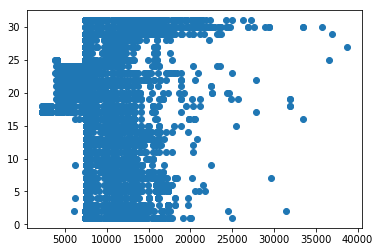

In [135]:
plt.scatter(df['price'],df['Day'])

Observation: We clearly see that price of the flight lies below 5000 Rupee's between 20 to 25 date 

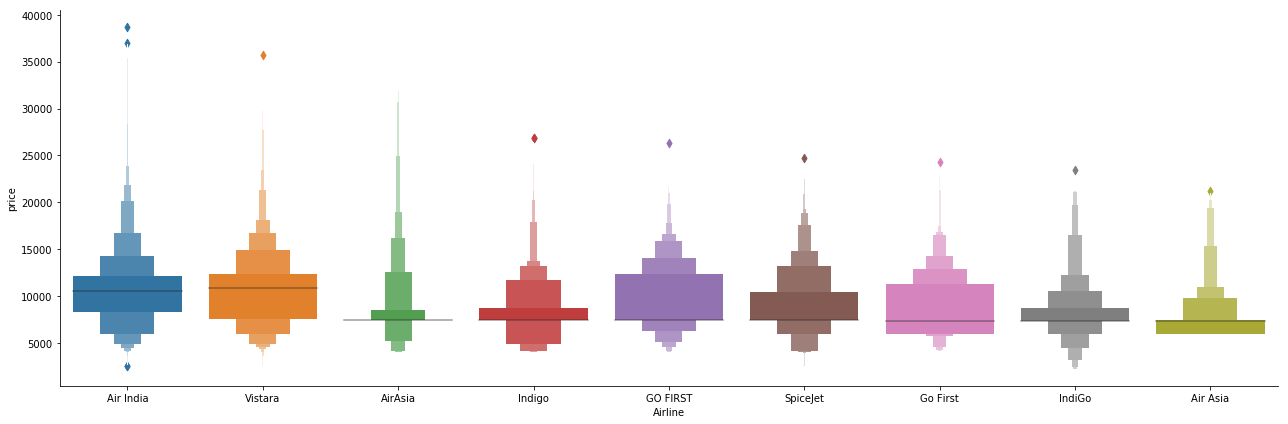

In [136]:

# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "price", x = "Airline", data = df.sort_values("price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

### Feature Selection
    Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

    **heatmap**

    **feature_importance_**
    
   


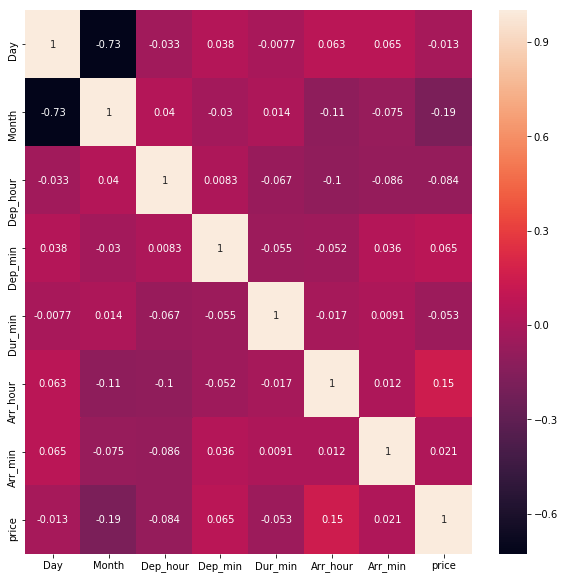

In [137]:
#To check the corr_mat  Heatmap
corr_hmap=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_hmap, annot=True)
plt.show()

In [138]:
#to display the
corr_matrix=df.corr()

#please find the top 10 positive relation with dependet variable SALES PRICE 
corr_matrix['price'].sort_values(ascending = False)

price       1.000000
Arr_hour    0.148662
Dep_min     0.064682
Arr_min     0.020918
Day        -0.012557
Dur_min    -0.052974
Dep_hour   -0.083973
Month      -0.185633
Name: price, dtype: float64

### Handeling the categorical values 

In [139]:
Airline = pd.get_dummies(df['Airline'])
Airline.head()

,Air Asia,Air India,AirAsia,GO FIRST,Go First,IndiGo,Indigo,SpiceJet,Vistara
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0


In [140]:
Source = pd.get_dummies(df["Source"])
Source.head()

,Bangalore,Chennai,New Delhi,bangalore
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [141]:
Destination = pd.get_dummies(df["Destination"])
Destination.head()

,Delhi,Mumbai
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [142]:
# Replacing Stops
df.replace({"non-stop": 0, "1-stop": 1, "2-stop": 2,"3-stop":3}, inplace = True)
df['stop']=pd.to_numeric(df['stop'])

In [143]:
# Concatenate dataframe --> df + Airline + Source + Destination
df = pd.concat([df, Airline, Source, Destination], axis = 1)

df.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [144]:
df.head()

,Day,Month,Route,Dep_hour,Dep_min,Dur_hour,Dur_min,Arr_hour,Arr_min,stop,...,IndiGo,Indigo,SpiceJet,Vistara,Bangalore,Chennai,New Delhi,bangalore,Delhi,Mumbai
0,25,10,BLR--->DEL,6,0,02,40,8,40,0,...,0,0,0,0,1,0,0,0,1,0
1,25,10,BLR--->DEL,21,15,02,40,23,55,0,...,0,0,0,0,1,0,0,0,1,0
2,25,10,BLR--->DEL,2,10,02,40,4,50,0,...,0,0,1,0,1,0,0,0,1,0
3,25,10,BLR--->DEL,12,55,02,45,15,40,0,...,0,1,0,0,1,0,0,0,1,0
4,25,10,BLR--->DEL,14,35,02,45,17,20,0,...,0,1,0,0,1,0,0,0,1,0


### Data Pre-processing

In [145]:
df.columns

Index(['Day', 'Month', 'Route', 'Dep_hour', 'Dep_min', 'Dur_hour', 'Dur_min',
       'Arr_hour', 'Arr_min', 'stop', 'price', 'Air Asia', 'Air India',
       'AirAsia', 'GO FIRST', 'Go First', 'IndiGo', 'Indigo', 'SpiceJet',
       'Vistara', 'Bangalore', 'Chennai', 'New Delhi', 'bangalore', 'Delhi',
       'Mumbai'],
      dtype='object')

In [146]:
#Spliting the data set X and y

X = df.loc[:, ['Air Asia', 'Air India',
       'AirAsia', 'GO FIRST', 'Go First', 'IndiGo', 'Indigo', 'SpiceJet',
       'Vistara','Bangalore', 'Chennai', 'New Delhi', 'bangalore', 'Delhi',
       'Mumbai', 'Day', 'Month', 'Dep_hour', 'Dep_min', 'Dur_hour', 'Dur_min',
       'Arr_hour', 'Arr_min', 'stop'
                                    ]]
y = df['price']

In [147]:
print(X.head(),y.head())

   Air Asia  Air India  AirAsia  GO FIRST  Go First  IndiGo  Indigo  SpiceJet  \
0         0          0        0         1         0       0       0         0   
1         0          0        0         1         0       0       0         0   
2         0          0        0         0         0       0       0         1   
3         0          0        0         0         0       0       1         0   
4         0          0        0         0         0       0       1         0   

   Vistara  Bangalore  ...  Mumbai  Day  Month  Dep_hour  Dep_min  Dur_hour  \
0        0          1  ...       0   25     10         6        0        02   
1        0          1  ...       0   25     10        21       15        02   
2        0          1  ...       0   25     10         2       10        02   
3        0          1  ...       0   25     10        12       55        02   
4        0          1  ...       0   25     10        14       35        02   

   Dur_min  Arr_hour  Arr_min stop  
0

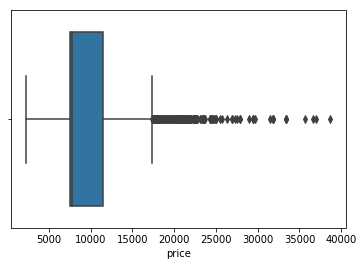

In [148]:
#box plot 
sns.boxplot(df['price'])
plt.show()

In [149]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [150]:
print(selection.feature_importances_)

[1.24378063e-03 4.39586723e-02 1.33710315e-02 9.69894720e-03
 2.56247535e-03 4.16305411e-03 8.41038566e-03 4.80532894e-03
 5.37424076e-02 1.09715960e-02 1.06979197e-02 1.16941204e-03
 2.48899221e-04 2.51297777e-03 1.27306480e-03 3.60199703e-01
 5.26458955e-02 5.79723143e-02 5.21615671e-02 6.46986672e-02
 4.24418146e-02 6.26351172e-02 5.83588312e-02 8.00561370e-02]


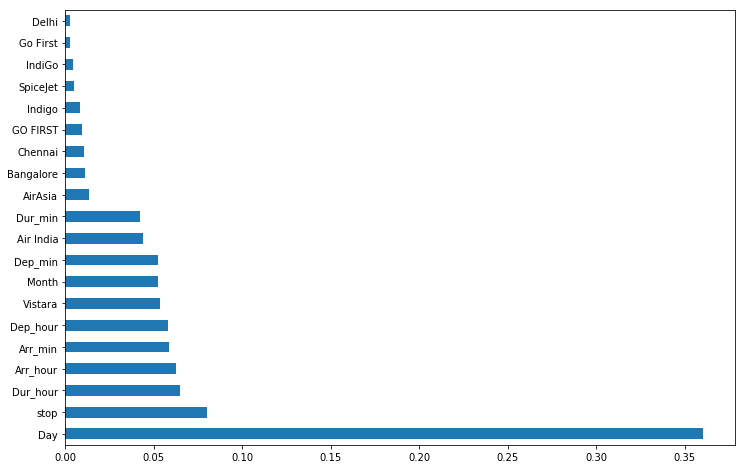

In [151]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

##### spliting the data into train set and test set

In [152]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Model Building

##### Random forest model

In [153]:
#Random forest model

from sklearn.ensemble import RandomForestRegressor
Forest = RandomForestRegressor()
Forest.fit(X_train, y_train)
y_pred = Forest.predict(X_test)
                        

In [154]:
#model traing score
Forest.score(X_train, y_train)

0.9411859625544666

In [155]:
#test score
Forest.score(X_test, y_test)

0.7011053685660491

In [156]:
Forest.score(X_test, y_test)

0.7011053685660491

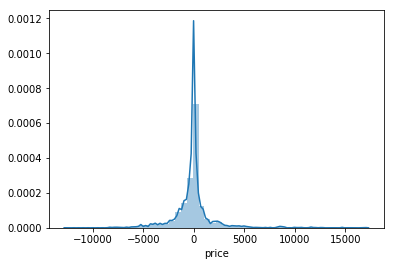

In [157]:
#y_test, and y_predicted plot
sns.distplot(y_test-y_pred)
plt.show()

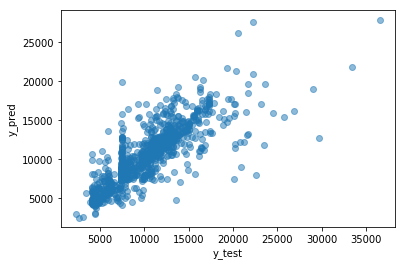

In [158]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [159]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2_score:',metrics.r2_score(y_test, y_pred))

MAE: 1038.0085097402598
MSE: 4063951.966613144
RMSE: 2015.9245934838793
R2_score: 0.7011053685660491


##### logistic regressionModel

In [160]:
#logistic regressionModel

from sklearn.linear_model import LogisticRegression
Logistic = LogisticRegression()
Logistic.fit(X_train,y_train)
l_prediction  =Logistic.predict(X_test)



In [161]:
Logistic.score(X_train,y_train)

0.43221302159441466

In [162]:
Logistic.score(X_test,y_test)

0.40324675324675324

In [163]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, l_prediction))
print('MSE:', metrics.mean_squared_error(y_test, l_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, l_prediction)))
print('R2_score:',metrics.r2_score(y_test, l_prediction))

MAE: 2008.837012987013
MSE: 12558371.63961039
RMSE: 3543.779287654691
R2_score: 0.07635968794184189


#### Decision Tree regression model

In [167]:
#decision Tree model 
from sklearn.tree import DecisionTreeRegressor
DTR=DecisionTreeRegressor()
DTR.fit(X_train,y_train)
DTR_pred=DTR.predict(X_test)


In [168]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, DTR_pred))
print('MSE:', metrics.mean_squared_error(y_test, DTR_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, DTR_pred)))
print('R2_score:',metrics.r2_score(y_test, DTR_pred))


MAE: 1086.7532467532467
MSE: 6240681.677597403
RMSE: 2498.1356403521013
R2_score: 0.5410117380209556


### Linear Regression model

In [96]:
from sklearn.linear_model import LinearRegression
Regressor=LinearRegression()
Regressor.fit(X_train,y_train)
pred =Regressor.predict(X_test)


In [97]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('R2_score:',metrics.r2_score(y_test, pred))

MAE: 2244.1503246753246
MSE: 9778928.469967533
RMSE: 3127.1278307686007
R2_score: 0.2807815533100888


#### Hyperparameter Tuning
    Choose following method for hyperparameter tuning
    RandomizedSearchCV --> Fast
    GridSearchCV
    Assign hyperparameters in form of dictionery
    Fit the model
    Check best paramters and best score

In [69]:
from sklearn.model_selection import RandomizedSearchCV

#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [70]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [72]:

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = Forest, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [73]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test=train_test_split(X,y, train_size=0.8, test_size=0.2,random_state=42 )

In [75]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.2s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   4.4s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.5s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.6s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [78]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [79]:

prediction = rf_random.predict(X_test)

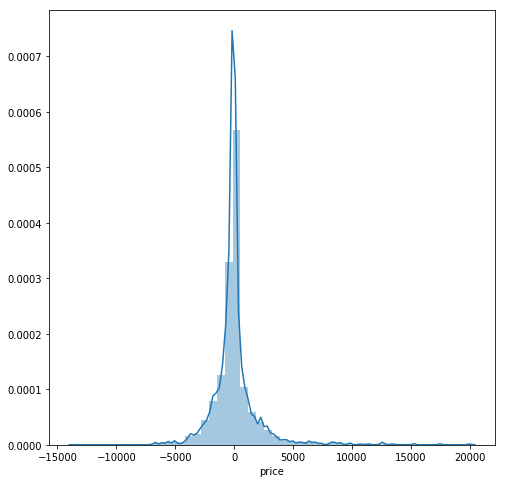

In [81]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

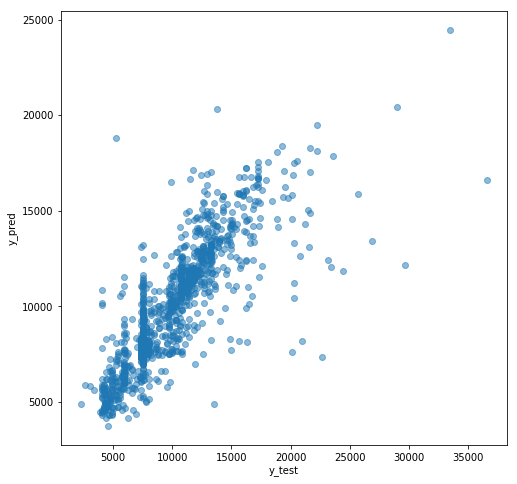

In [82]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [83]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1042.4846755476253
MSE: 4034480.7952943686
RMSE: 2008.601701506391


In [84]:
y_prediction = rf_random.predict(X_test)
metrics.r2_score(y_test, y_prediction)

0.7032729076909254

### Saving the model

In [86]:
import pickle
# open a file, where you ant to store the data
file = open('Forest.pkl', 'wb')

# dump information to that file
pickle.dump(Forest, file)

In [87]:

model = open('Forest.pkl','rb')
forest = pickle.load(model)

#### Data Analysis insights

In [ ]:
### Data Analysis
After cleaning the data, you have to do some analysis on the data.

1. Do airfares change frequently?
Ans.Yes, Based on the revenue optimization per each flight vital important for airlines profitablity ,it includes the proper 
application of revenue managment and pricing system  togather with impoved mathodlogy ,profitablility calculation lies in allocation
of revenues and expense of each individual fligh

2. Do they move in small increments or in large jumps?
 Ans. large jumps, If you buy a ticket before 30 days of date of journey you will get arround 56% less price then date of journey day price 
      20 day before date of journey 10% to 12% less price of date of journey, after it wont changes much it will be same 
       
    Also flight ticket price depends how many peoples already booked the filght if large number peoples already booked then pricing 
    system not increase flight charges near to the date of journey, It total depends on revenue pricinng system and crowd of travellers 
 

--->if your are travelling on weekends or month ends cost the flight charges 10% to 12%  more then the week days 

3. Do they tend to go up or down over time?
Ans. Price of the flight goes up only down over time but its not reduces the price over time 

4. What is the best time to buy so that the consumer can save the most by taking the least risk?
Ans. Consumer should buy the ticket before 30 days of date of joureney so they can save up to 50% to 56%, 
it can be week ends or month end there is no fare changes before 30 days to date of journey,
with in 30 days weekends and month ends price changes 


4. Does price increase as we get near to departure date? Is Indigo cheaper than Jet Airways? 
Ans. Yes, price of the flight will increase step by step near to departure date, like  
----> Indigo is cheaper then spice jet Airways

5. Are morning flights expensive?
Ans: No,As per the demostic flight of india all price of the flights will be same throught the day


"""Observation : If you book the filght ticket befor 29 days of traveling date you will get 56.1 percent less price of journey date booking ticket
price of ticket on joureny date = 7487 Rs(20-oct-2021)
before 29 days of jouerny date  = 4200 Rs(19-Nov-2021)

4200 * 100
--------------  56.1 %
   7487

"""